# main_test6.py

初始的代码报错，修改一下。


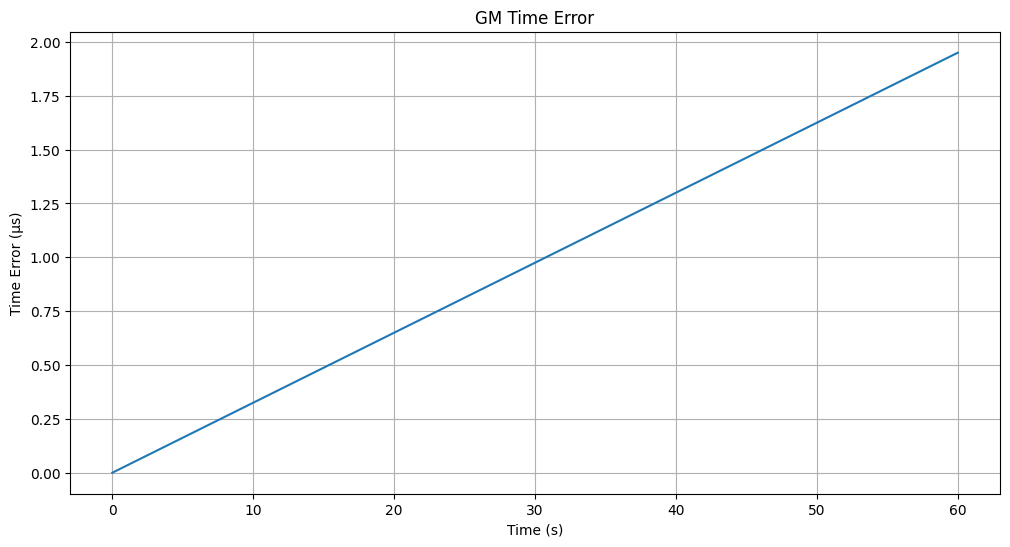

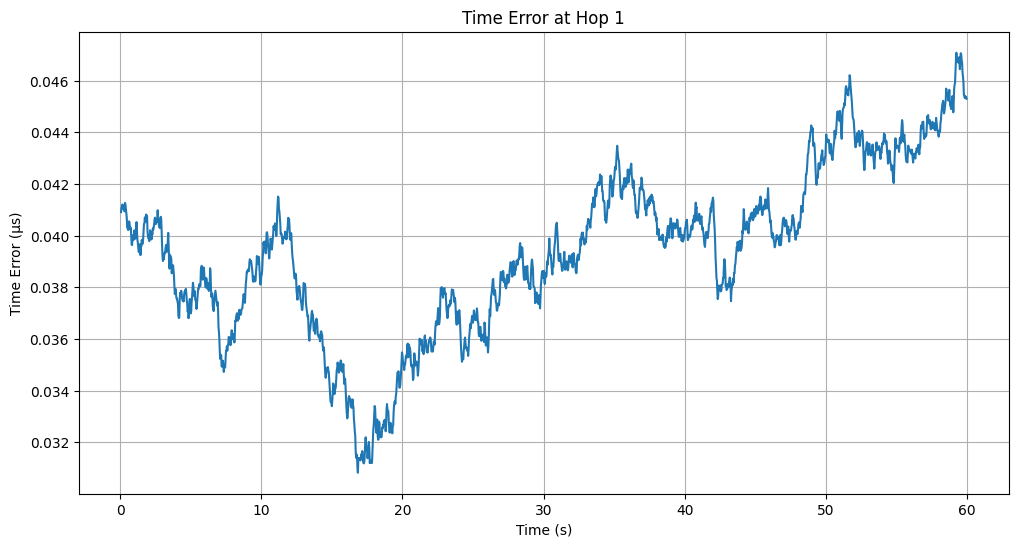

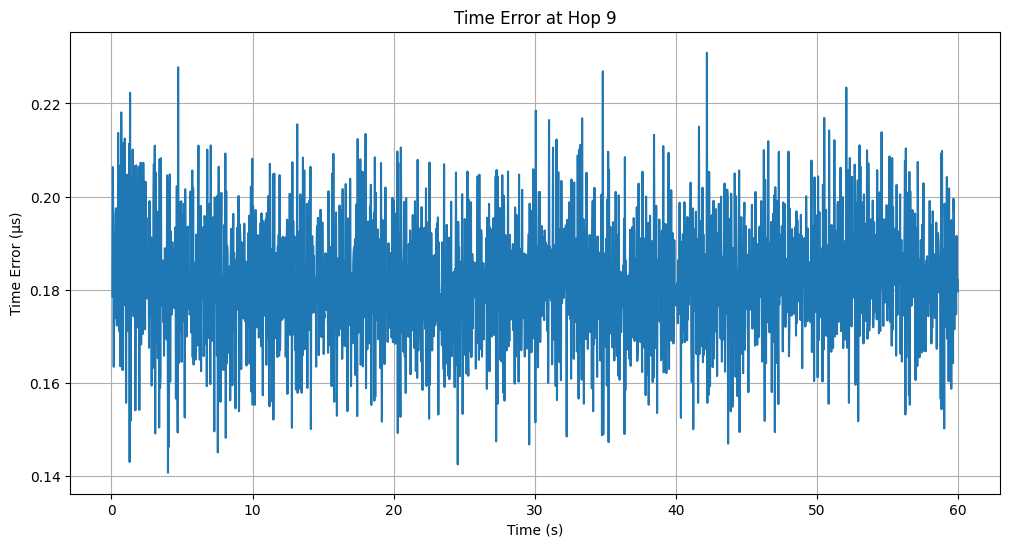

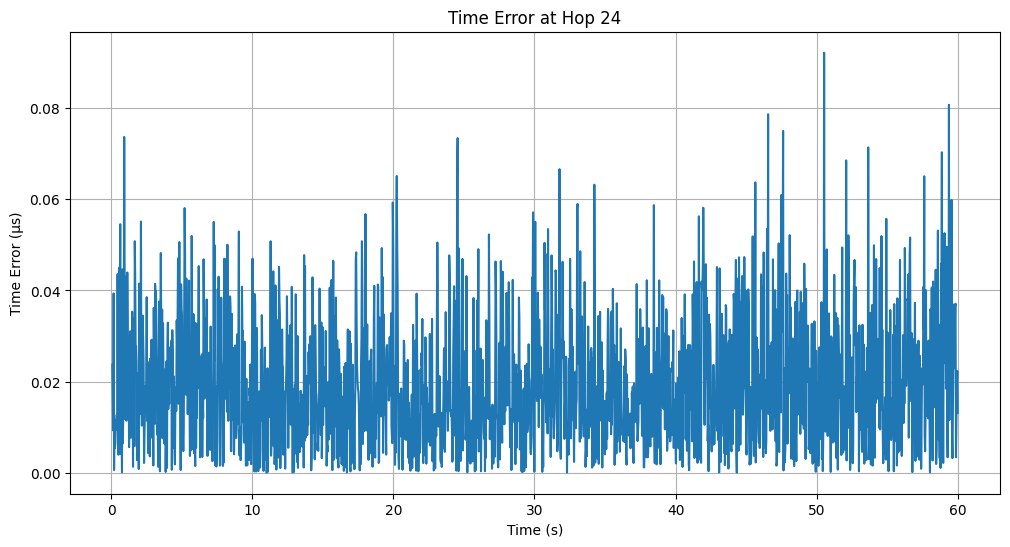

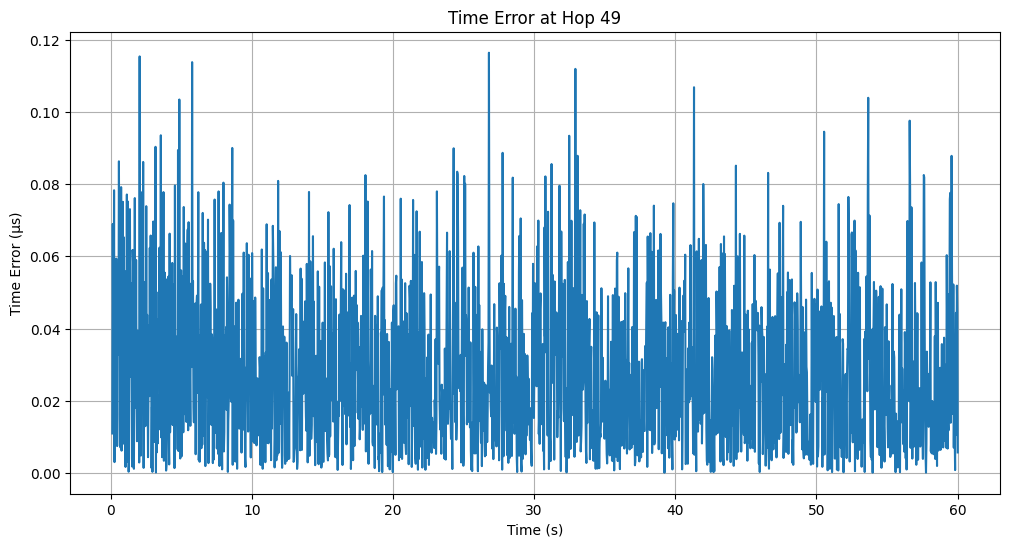

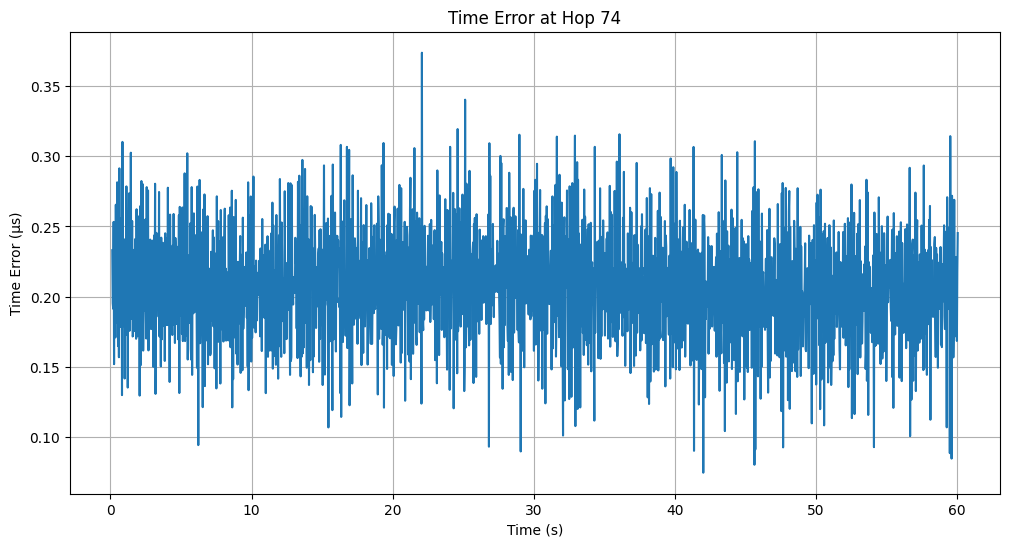

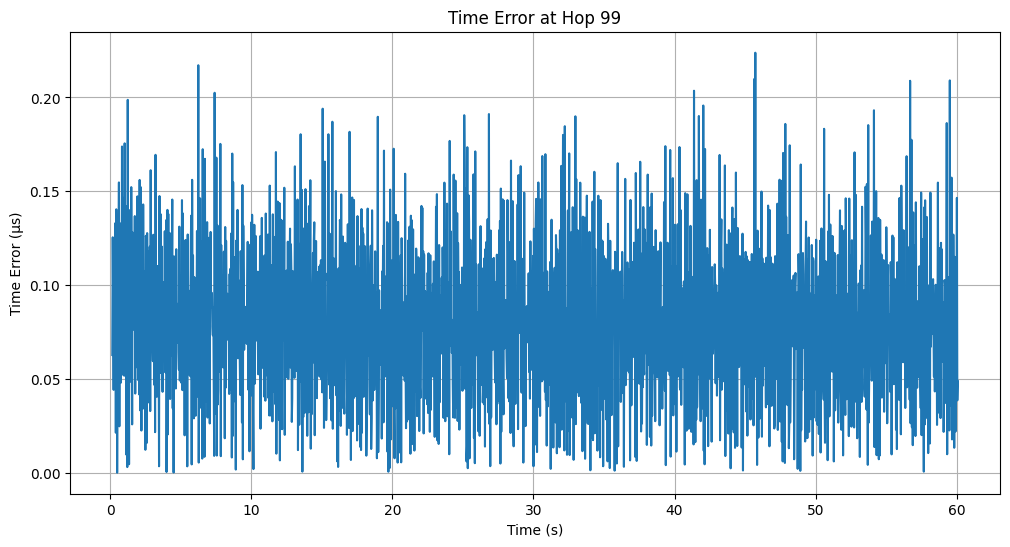

In [3]:
import heapq
import numpy as np
import matplotlib.pyplot as plt

# 常量配置
NUM_NODES = 100          # 链式网络中的节点数
SYNC_INTERVAL = 0.03125  # 同步间隔 (31.25 ms)
PHY_JITTER = 8e-9        # PHY抖动范围 (8 ns)
CLOCK_GRANULARITY = 8e-9 # 时钟粒度 (8 ns)
MAX_DRIFT_RATE = 10e-6   # 最大漂移率 (±10 ppm)
SIM_TIME = 100.0         # 仿真总时长 (秒)
PDELAY_INTERVAL = 1.0    # 传播延迟测量间隔 (1 s)
DRIFT_RATE_CHANGE = 1e-6 # 漂移率每秒变化范围 [0, 1] ppm/s

class Clock:
    def __init__(self, is_grandmaster=False):
        self.is_grandmaster = is_grandmaster
        # Grandmaster时钟漂移率设为极小的非零值（例如±0.1 ppm）
        if self.is_grandmaster:
            self.drift_rate = np.random.uniform(-0.1e-6, 0.1e-6)
        else:
            # 初始漂移率在±10 ppm范围内
            self.drift_rate = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
        self.offset = 0.0  # 相对于理想时钟的偏移
        self.time = 0.0    # 本地时间
    
    def update(self, delta_t):
        # 漂移率变化更加符合实际情况，变化频率较低
        if not self.is_grandmaster:
            # 每次更新有5%的概率发生变化，减小变化幅度
            if np.random.random() < 0.05:
                self.drift_rate += np.random.uniform(-DRIFT_RATE_CHANGE/5, DRIFT_RATE_CHANGE/5) * delta_t
                self.drift_rate = np.clip(self.drift_rate, -MAX_DRIFT_RATE, MAX_DRIFT_RATE)
        
        # 更新本地时间（考虑漂移率）
        self.time += delta_t * (1 + self.drift_rate)
        return self.time
    
    def adjust(self, offset):
        # 调整本地时钟的偏移量（保留漂移率的影响）
        self.offset += offset
        self.time += offset

class Node:
    def __init__(self, node_id, is_grandmaster=False):
        self.id = node_id
        self.is_grandmaster = is_grandmaster
        self.clock = Clock(is_grandmaster=self.is_grandmaster)
        
        # 节点物理层参数
        self.residence_time = 0.5e-3 if is_grandmaster else 1e-3  # 驻留时间
        self.propagation_delay = 50e-9  # 初始传播延迟默认为50ns
        
        self.last_sync_time = 0.0
        self.last_pdelay_time = 0.0
        self.asymmetry = 0.0  # 链路非对称性，默认为0
        
        # 速率比相关参数
        self.rate_ratio = 1.0  # 本地与GM的速率比
        self.neighbor_rate_ratio = 1.0  # 本地与邻居的速率比
        
        # 误差记录数组
        self.sync_errors = []  # 同步误差记录
        self.time_errors = []  # 时间误差记录（相对于GM）
        self.gm_time_errors = []  # GM自身时间误差记录（相对于理想时钟）
        
        # 保存传播延迟测量的历史值用于滤波
        self.pdelay_history = []
    
    def receive_sync(self, sync_time, correction_field):
        """接收同步消息并调整本地时钟"""
        # 接收Sync消息时添加抖动和时钟粒度
        phy_jitter = np.random.uniform(0, PHY_JITTER) 
        gran_effect = np.random.uniform(0, CLOCK_GRANULARITY)
        
        # 接收时间包含传播延迟和物理层效应
        actual_receive_time = sync_time + self.propagation_delay + phy_jitter + gran_effect
        
        # 计算本地时间与GM的偏差
        local_time = self.clock.time
        gm_time = sync_time + correction_field
        error = local_time - gm_time
        
        # 调整本地时钟（保留漂移率的影响）
        self.clock.adjust(-error)
        
        # 记录时间误差
        if self.is_grandmaster:
            # GM自身的时间误差（相对于理想时间）
            self.gm_time_errors.append((self.clock.time, abs(error)))
        else:
            # 下游节点的时间误差（相对于GM）
            self.time_errors.append((self.clock.time, abs(error)))
        
        # 添加驻留时间并计算转发时间
        forward_time = actual_receive_time + self.residence_time
        
        return forward_time, error
    
    def measure_pdelay(self, neighbor, current_time):
        """测量到邻居节点的传播延迟"""
        # PHY抖动均匀分布在0-8ns
        j1 = np.random.uniform(0, PHY_JITTER)
        j2 = np.random.uniform(0, PHY_JITTER)
        j3 = np.random.uniform(0, PHY_JITTER)
        j4 = np.random.uniform(0, PHY_JITTER)
        
        # 时钟粒度影响
        g1 = np.random.uniform(0, CLOCK_GRANULARITY)
        g2 = np.random.uniform(0, CLOCK_GRANULARITY)
        
        # 发送Pdelay_Req消息
        t1 = self.clock.time
        # t2包含物理层抖动和时钟粒度的影响
        t2 = neighbor.clock.time + j1 + g1
        
        # 发送Pdelay_Resp消息
        t3 = neighbor.clock.time
        # t4包含物理层抖动和时钟粒度的影响
        t4 = self.clock.time + j2 + g2
        
        # 计算传播延迟（考虑非对称性）
        # 根据论文中的公式(4)
        mean_delay = ((t4 - t1) - self.neighbor_rate_ratio * (t3 - t2)) / 2
        
        # 将非对称性加入测量值
        measured_delay = mean_delay + self.asymmetry
        
        # 使用历史值滤波，减少测量噪声影响
        self.pdelay_history.append(measured_delay)
        if len(self.pdelay_history) > 10:  # 保留最近10次测量
            self.pdelay_history.pop(0)
        
        # 使用均值滤波
        self.propagation_delay = np.mean(self.pdelay_history)
        
        # 更新邻居速率比
        # 实际实现中，此处应该使用邻居时钟的真实速率
        self.neighbor_rate_ratio = (1 + neighbor.clock.drift_rate) / (1 + self.clock.drift_rate)
        
        # 更新自身与GM的速率比
        if not self.is_grandmaster:
            # 使用公式(1): r_i = r_(i-1) * nr_i
            self.rate_ratio = neighbor.rate_ratio * self.neighbor_rate_ratio
        
        return self.propagation_delay

class Network:
    def __init__(self):
        self.nodes = [Node(i, is_grandmaster=(i==0)) for i in range(NUM_NODES)]
        self.grandmaster = self.nodes[0]
        self.event_queue = []
        self.current_time = 0.0
        self.event_counter = 0
        
        # 记录网络统计信息
        self.error_stats = {node_id: {'errors': [], 'max_error': 0, 'avg_error': 0} 
                           for node_id in range(NUM_NODES)}
    
    def schedule_event(self, time, callback, *args):
        """调度事件到事件队列"""
        heapq.heappush(self.event_queue, (time, self.event_counter, callback, args))
        self.event_counter += 1
    
    def run_simulation(self):
        """运行仿真"""
        # 首先初始化网络中的速率比
        self._initialize_rate_ratios()
        
        # 添加GM时间误差跟踪
        self.schedule_event(0.0, self.track_gm_error, self.grandmaster)
        
        # 调度初始同步事件
        self.schedule_event(0.0, self.send_sync, self.grandmaster)
        
        # 调度传播延迟测量
        for i in range(1, NUM_NODES):
            self.schedule_event(0.0, self.measure_pdelay, self.nodes[i], self.nodes[i-1])
        
        # 主事件循环
        while self.event_queue and self.current_time < SIM_TIME:
            time, _, callback, args = heapq.heappop(self.event_queue)
            
            # 更新所有节点的时钟到当前时间
            delta_t = time - self.current_time
            for node in self.nodes:
                node.clock.update(delta_t)
            
            self.current_time = time
            callback(*args)
        
        # 仿真结束后计算统计信息
        self._calculate_statistics()
    
    def _initialize_rate_ratios(self):
        """初始化所有节点的速率比"""
        for i in range(1, NUM_NODES):
            prev_node = self.nodes[i-1]
            curr_node = self.nodes[i]
            
            # 邻居速率比
            curr_node.neighbor_rate_ratio = (1 + prev_node.clock.drift_rate) / (1 + curr_node.clock.drift_rate)
            
            # 与GM的速率比
            if i == 1:
                curr_node.rate_ratio = curr_node.neighbor_rate_ratio
            else:
                curr_node.rate_ratio = prev_node.rate_ratio * curr_node.neighbor_rate_ratio
    
    def track_gm_error(self, gm_node):
        """记录GM与理想时间的误差"""
        ideal_time = self.current_time
        gm_time = gm_node.clock.time
        error = gm_time - ideal_time
        gm_node.gm_time_errors.append((self.current_time, abs(error)))
        self.schedule_event(self.current_time + SYNC_INTERVAL/4, self.track_gm_error, gm_node)
    
    def send_sync(self, node):
        """发送同步消息到整个网络"""
        sync_time = self.current_time
        correction_field = 0.0
        
        for i in range(1, NUM_NODES):
            # 当前节点接收同步消息
            forward_time, error = self.nodes[i].receive_sync(sync_time, correction_field)
            
            # 记录同步误差
            self.error_stats[i]['errors'].append(abs(error))
            
            # 更新校正字段，按照论文中的公式(2)
            # C_i = C_(i-1) + D_(i-1) + (t_S_i - t_R_i)*r_i
            prev_node = self.nodes[i-1]
            curr_node = self.nodes[i]
            
            # 计算驻留时间 (t_S_i - t_R_i)
            residence_time = curr_node.residence_time
            
            # 更新校正字段
            correction_field += prev_node.propagation_delay
            correction_field += residence_time * curr_node.rate_ratio
            
            # 更新同步时间为转发时间
            sync_time = forward_time
        
        # 调度下一次同步事件
        self.schedule_event(self.current_time + SYNC_INTERVAL, self.send_sync, node)
    
    def measure_pdelay(self, node, neighbor):
        """测量节点间的传播延迟"""
        node.measure_pdelay(neighbor, self.current_time)
        self.schedule_event(self.current_time + PDELAY_INTERVAL, self.measure_pdelay, node, neighbor)
    
    def _calculate_statistics(self):
        """计算仿真统计信息"""
        for node_id in range(NUM_NODES):
            errors = self.error_stats[node_id]['errors']
            if errors:
                self.error_stats[node_id]['max_error'] = max(errors)
                self.error_stats[node_id]['avg_error'] = sum(errors) / len(errors)
    
    def calculate_sync_probability(self, precision_thresholds=None):
        """计算不同精度阈值下的同步概率"""
        if precision_thresholds is None:
            # 微秒级别的精度阈值
            precision_thresholds = [0.25e-6, 0.5e-6, 0.75e-6, 1e-6, 1.25e-6, 1.5e-6, 1.75e-6, 2e-6]
        
        # 要分析的节点
        nodes_to_analyze = [1, 10, 25, 50, 75, 99]
        
        results = {}
        for node_id in nodes_to_analyze:
            if node_id >= NUM_NODES:
                continue
                
            errors = self.error_stats[node_id]['errors']
            if not errors:
                continue
                
            node_results = []
            for threshold in precision_thresholds:
                # 计算同步概率：误差小于阈值的比例
                in_sync_count = sum(1 for e in errors if e < threshold)
                probability = in_sync_count / len(errors) if errors else 0
                node_results.append((threshold, probability))
            
            results[node_id] = node_results
        
        return results
    
    def plot_results(self, hop=None):
        """绘制仿真结果"""
        if hop is not None:
            # 绘制某一跳的时间误差
            if hop < 1 or hop >= NUM_NODES:
                raise ValueError(f"Invalid hop: {hop}. Must be between 1 and {NUM_NODES - 1}.")
            
            node = self.nodes[hop]
            if not node.time_errors:
                print(f"No time error data for hop {hop}")
                return
                
            times, errors = zip(*node.time_errors)
            
            # 跳过前几个数据点（初始化阶段）
            start_idx = min(len(times) // 10, 10)
            times = times[start_idx:]
            errors = errors[start_idx:]
            
            plt.figure(figsize=(12, 6))
            plt.plot(times, np.array(errors)*1e6)  # 转换为微秒
            plt.xlabel('Time (s)')
            plt.ylabel('Time Error (μs)')
            plt.title(f'Time Error at Hop {hop}')
            plt.grid(True)
            plt.show()
        else:
            # 绘制GM自身的时间误差
            if not self.grandmaster.gm_time_errors:
                print("No GM time error data available")
                return
                
            gm_times, gm_errors = zip(*self.grandmaster.gm_time_errors)
            
            # 跳过前几个数据点
            start_idx = min(len(gm_times) // 10, 10)
            gm_times = gm_times[start_idx:]
            gm_errors = gm_errors[start_idx:]
            
            plt.figure(figsize=(12, 6))
            plt.plot(gm_times, np.array(gm_errors)*1e6)  # 转换为微秒
            plt.xlabel('Time (s)')
            plt.ylabel('Time Error (μs)')
            plt.title('GM Time Error')
            plt.grid(True)
            plt.show()
    
    def plot_sync_probability(self):
        """绘制同步概率结果，复现论文中的图9"""
        precision_thresholds = [0.25e-6, 0.5e-6, 0.75e-6, 1e-6, 1.25e-6, 1.5e-6, 1.75e-6, 2e-6]
        results = self.calculate_sync_probability(precision_thresholds)
        
        plt.figure(figsize=(12, 8))
        
        # 为每个节点绘制一条线
        for node_id, node_results in results.items():
            if not node_results:
                continue
                
            thresholds, probabilities = zip(*node_results)
            plt.plot([t*1e6 for t in thresholds], probabilities, 
                     marker='o', label=f'Node {node_id}')
        
        plt.xlabel('Precision Threshold (μs)')
        plt.ylabel('Probability of Synchronization')
        plt.title('Synchronization Precision Probability')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    def plot_precision_by_hop(self, precision=1e-6):
        """绘制不同跳数下的同步概率，复现论文中的图10"""
        # 计算每个节点在给定精度下的同步概率
        hop_probs = []
        
        for node_id in range(1, NUM_NODES):
            errors = self.error_stats[node_id]['errors']
            if not errors:
                hop_probs.append(0)
                continue
                
            # 计算同步概率
            in_sync_count = sum(1 for e in errors if e < precision)
            probability = in_sync_count / len(errors)
            hop_probs.append(probability)
        
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, NUM_NODES), hop_probs, marker='o')
        plt.xlabel('Hop Number')
        plt.ylabel(f'Probability of Synchronization within {precision*1e6} μs')
        plt.title('Synchronization Probability vs. Hop Number')
        plt.grid(True)
        plt.ylim(0, 1.05)
        plt.show()
    
    def plot_error_distribution(self, hop):
        """绘制误差分布，复现论文中的图8"""
        if hop < 1 or hop >= NUM_NODES:
            raise ValueError(f"Invalid hop: {hop}. Must be between 1 and {NUM_NODES - 1}.")
        
        errors = self.error_stats[hop]['errors']
        if not errors:
            print(f"No error data for hop {hop}")
            return
        
        # 将误差转换为微秒
        errors_us = [e * 1e6 for e in errors]
        
        plt.figure(figsize=(12, 6))
        
        # 绘制带PHY抖动的误差直方图
        plt.hist(errors_us, bins=50, alpha=0.7, color='blue', 
                 label=f'With PHY Jitter and Clock Granularity')
        
        plt.xlabel('Time Error (μs)')
        plt.ylabel('Frequency')
        plt.title(f'Error Distribution at Hop {hop}')
        plt.grid(True)
        plt.legend()
        plt.show()

if __name__ == "__main__":
    network = Network()
    network.run_simulation()
    
    # 绘制GM自身的时间误差
    network.plot_results()
    
    # 绘制某一跳的时间误差
    network.plot_results(1)   # 第一跳（索引1）
    network.plot_results(10)  # 第十跳
    network.plot_results(99)  # 最后一跳
    
    # 绘制同步概率图
    network.plot_sync_probability()
    
    # 绘制不同跳数下的同步概率
    network.plot_precision_by_hop(1e-6)  # 1μs精度
    
    # 绘制误差分布
    network.plot_error_distribution(99)  # 最后一跳的误差分布